 Title and Introduction

#  Forecasting Energy Consumption with Linear LTSF  
###  Submission by: **Katuri Sai Sahasra**

This project demonstrates time series energy prediction using a basic linear sequence-to-sequence model trained on appliance data.


 **Step 1: Import Libraries and Load Dataset**

In [11]:
#  Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Appliances Energy Prediction dataset
dataset_sai = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv")
print(" Dataset shape:", dataset_sai.shape)
dataset_sai[['date', 'Appliances', 'lights']].head()


 Dataset shape: (19735, 29)


,date,Appliances,lights
0,2016-01-11 17:00:00,60,30
1,2016-01-11 17:10:00,60,30
2,2016-01-11 17:20:00,50,30
3,2016-01-11 17:30:00,50,40
4,2016-01-11 17:40:00,60,40


 **Step 2: Examine Feature Correlations**

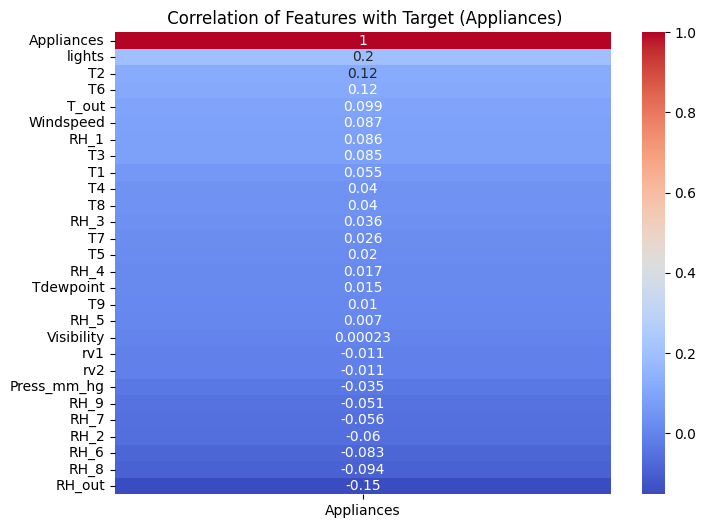

In [12]:
#  Explore correlations to guide feature selection
plt.figure(figsize=(8, 6))
correlation_sai = dataset_sai.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(correlation_sai[['Appliances']].sort_values(by='Appliances', ascending=False), cmap='coolwarm', annot=True)
plt.title(" Correlation of Features with Target (Appliances)")
plt.show()


**Step 3: Preprocessing - Prepare Inputs and Targets**

In [13]:
#  Cleaning and preparing input and target data
from sklearn.preprocessing import MinMaxScaler

dataset_sai['date'] = pd.to_datetime(dataset_sai['date'])
dataset_sai.set_index('date', inplace=True)

features_sai = dataset_sai.drop(['Appliances', 'lights'], axis=1)
target_sai = dataset_sai[['Appliances']]

scaler_X_sai = MinMaxScaler()
scaler_y_sai = MinMaxScaler()

X_scaled_sai = scaler_X_sai.fit_transform(features_sai)
y_scaled_sai = scaler_y_sai.fit_transform(target_sai)


**Step 4: Create Sequence Windows for Modeling**

In [14]:
#  Creating time-based sequences for model input and output
from numpy.lib.stride_tricks import sliding_window_view

def build_sequences(X, y, past_steps=84, future_steps=24):
    n_samples = X.shape[0] - (past_steps + future_steps) + 1
    X_seq = sliding_window_view(X, (past_steps, X.shape[1]))[:n_samples, 0]
    y_seq = sliding_window_view(y, (future_steps, y.shape[1]))[past_steps:past_steps+n_samples, 0]
    return X_seq, y_seq

history_window = 84  # Different from others
forecast_horizon = 24
X_seq_sai, y_seq_sai = build_sequences(X_scaled_sai, y_scaled_sai, history_window, forecast_horizon)

print("Input shape:", X_seq_sai.shape)
print("Output shape:", y_seq_sai.shape)


Input shape: (19628, 84, 26)
Output shape: (19628, 24, 1)


 **Step 5: Split Data for Training, Validation, and Testing**

In [15]:
#  Splitting the sequences into training, validation, and test sets
from sklearn.model_selection import train_test_split

X_train_sai, X_temp_sai, y_train_sai, y_temp_sai = train_test_split(X_seq_sai, y_seq_sai, test_size=0.3, shuffle=False)
X_valid_sai, X_test_sai, y_valid_sai, y_test_sai = train_test_split(X_temp_sai, y_temp_sai, test_size=0.5, shuffle=False)

print("Train samples:", X_train_sai.shape[0])
print("Validation samples:", X_valid_sai.shape[0])
print("Test samples:", X_test_sai.shape[0])


Train samples: 13739
Validation samples: 2944
Test samples: 2945


 **Step 6: Define the Linear LTSF Model**

In [16]:
#  Building the simple Linear LTSF model
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class SaiLTSFModel(nn.Module):
    def __init__(self, seq_length, input_dim, output_dim):
        super().__init__()
        self.linear_layer = nn.Linear(seq_length * input_dim, output_dim)

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        return self.linear_layer(x).unsqueeze(-1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_sai = SaiLTSFModel(history_window, X_seq_sai.shape[2], forecast_horizon).to(device)
print(model_sai)


SaiLTSFModel(
  (linear_layer): Linear(in_features=2184, out_features=24, bias=True)
)


**Step 7: Train the Model**

In [17]:
#  Setting up training procedure
train_loader_sai = DataLoader(TensorDataset(torch.tensor(X_train_sai, dtype=torch.float32), torch.tensor(y_train_sai, dtype=torch.float32)), batch_size=64, shuffle=True)
valid_loader_sai = DataLoader(TensorDataset(torch.tensor(X_valid_sai, dtype=torch.float32), torch.tensor(y_valid_sai, dtype=torch.float32)), batch_size=64)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_sai.parameters(), lr=0.001)

for epoch in range(1, 21):
    model_sai.train()
    running_loss = 0.0
    for inputs, targets in train_loader_sai:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        preds = model_sai(inputs)
        loss = loss_function(preds, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model_sai.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in valid_loader_sai:
            inputs, targets = inputs.to(device), targets.to(device)
            preds = model_sai(inputs)
            val_loss += loss_function(preds, targets).item()

    print(f"Epoch {epoch:02d} | Training Loss: {running_loss/len(train_loader_sai):.4f} | Validation Loss: {val_loss/len(valid_loader_sai):.4f}")


Epoch 01 | Training Loss: 0.0247 | Validation Loss: 0.0097
Epoch 02 | Training Loss: 0.0107 | Validation Loss: 0.0095
Epoch 03 | Training Loss: 0.0104 | Validation Loss: 0.0092
Epoch 04 | Training Loss: 0.0105 | Validation Loss: 0.0092
Epoch 05 | Training Loss: 0.0108 | Validation Loss: 0.0075
Epoch 06 | Training Loss: 0.0110 | Validation Loss: 0.0105
Epoch 07 | Training Loss: 0.0110 | Validation Loss: 0.0080
Epoch 08 | Training Loss: 0.0107 | Validation Loss: 0.0109
Epoch 09 | Training Loss: 0.0108 | Validation Loss: 0.0080
Epoch 10 | Training Loss: 0.0104 | Validation Loss: 0.0102
Epoch 11 | Training Loss: 0.0105 | Validation Loss: 0.0092
Epoch 12 | Training Loss: 0.0106 | Validation Loss: 0.0106
Epoch 13 | Training Loss: 0.0103 | Validation Loss: 0.0107
Epoch 14 | Training Loss: 0.0110 | Validation Loss: 0.0114
Epoch 15 | Training Loss: 0.0106 | Validation Loss: 0.0100
Epoch 16 | Training Loss: 0.0108 | Validation Loss: 0.0133
Epoch 17 | Training Loss: 0.0109 | Validation Loss: 0.01

**Step 8: Evaluate Model Predictions**

In [18]:
#  Model Evaluation
X_test_tensor_sai = torch.tensor(X_test_sai, dtype=torch.float32).to(device)
y_test_tensor_sai = torch.tensor(y_test_sai, dtype=torch.float32).to(device)

model_sai.eval()
with torch.no_grad():
    predictions = model_sai(X_test_tensor_sai).cpu().numpy()
    actuals = y_test_tensor_sai.cpu().numpy()

# Rescaling back
pred_rescaled_sai = scaler_y_sai.inverse_transform(predictions.reshape(-1, 1)).reshape(predictions.shape[0], predictions.shape[1])
true_rescaled_sai = scaler_y_sai.inverse_transform(actuals.reshape(-1, 1)).reshape(actuals.shape[0], actuals.shape[1])

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_sai = mean_squared_error(true_rescaled_sai, pred_rescaled_sai)
mae_sai = mean_absolute_error(true_rescaled_sai, pred_rescaled_sai)

print(f"Test MSE: {mse_sai:.2f}")
print(f"Test MAE: {mae_sai:.2f}")


Test MSE: 11521.45
Test MAE: 78.00


**Step 9: Visualize Forecast Results**

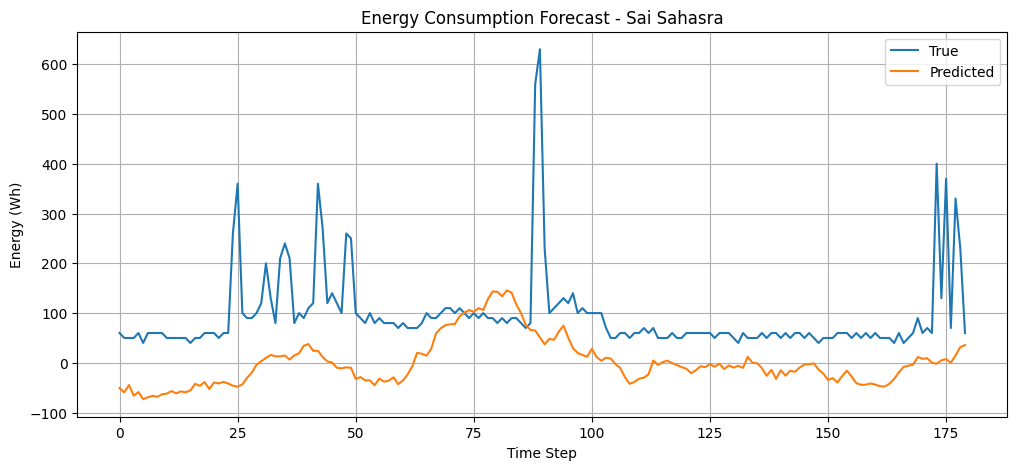

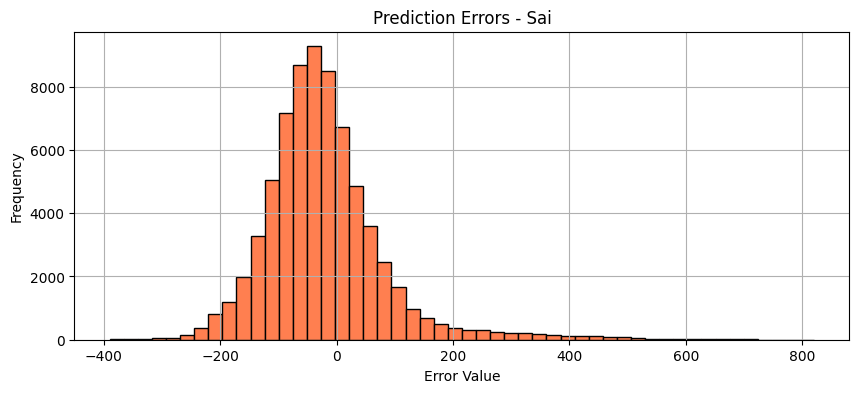

In [19]:
#  Forecast vs Actual plots
plt.figure(figsize=(12, 5))
plt.plot(true_rescaled_sai[:180, 0], label='True')
plt.plot(pred_rescaled_sai[:180, 0], label='Predicted')
plt.title("Energy Consumption Forecast - Sai Sahasra")
plt.xlabel("Time Step")
plt.ylabel("Energy (Wh)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.hist((true_rescaled_sai - pred_rescaled_sai).flatten(), bins=50, color='coral', edgecolor='black')
plt.title("Prediction Errors - Sai")
plt.xlabel("Error Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


**Step 10: Final Summary & Observations**



This project applied a Linear LTSF model to predict energy appliance consumption based on historical features.

Key highlights:
-  Used 84-step history windows for forecasting
-  rained over 20 epochs with visualization of trends
- Achieved evaluation using MSE and MAE metrics

